In [1]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#load the data matrics
matrix_4st=np.loadtxt('matrix64.txt')
print('4 state scenario matrics has the shape:',matrix_4st.shape)


4 state scenario matrics has the shape: (34738, 28)


In [3]:

unique4 = np.unique(matrix_4st,axis =0)
print(unique4.shape)

(20022, 28)


## Max-Min Normalization
$$
x^{\prime}=\frac{x-\min (x)}{\max (x)-\min (x)}
$$

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler4 = MinMaxScaler()
scaler4.fit(unique4)
normal4 = scaler4.transform(unique4)

In [5]:
normal4

array([[0.        , 0.0625    , 0.0625    , ..., 0.        , 0.07692308,
        0.08333333],
       [0.        , 0.0625    , 0.0625    , ..., 0.        , 0.15384615,
        0.        ],
       [0.        , 0.0625    , 0.0625    , ..., 0.        , 0.        ,
        0.16666667],
       ...,
       [0.875     , 0.9375    , 1.        , ..., 0.        , 0.76923077,
        0.41666667],
       [0.9375    , 0.9375    , 0.9375    , ..., 0.        , 0.76923077,
        0.33333333],
       [1.        , 1.        , 1.        , ..., 0.        , 0.76923077,
        0.41666667]])

## Model training using Loop driving data

![loop](..\Masterarbeit\pic\kreisfahrt.jpg)

In [6]:
n_input_1 = 7
n_input_2 = 14
n_input_3 = 21
n_input_4 = 28

In [7]:
# Labeling data
# from pyod.models.iforest import IForest
# from sklearn.manifold import TSNE
# iforest2 = IForest()
# iforest2.fit(unique2)

# tsne = TSNE(n_components = 2)

# #visualization the labeled data in 2D
# X2 = tsne.fit_transform(unique2)
# plt.figure(figsize=(20, 20))
# plt.scatter(X2[:,0], X2[:,1], c = iforest2.labels_)
# plt.show()

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Parameters
learning_rate = 0.01
training_epochs = 130
batch_size = 128   # the batch size can not exceed the size of the data.

In [9]:
# Building the encoder
def encoder(x,weights,biases):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2

In [10]:
# Building the decoder
def decoder(x,weights,biases):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

In [11]:
tf.reset_default_graph()

In [12]:
from sklearn.utils import shuffle
def one_class_learning(dataset,testset):
    # Network Parameters
    n_input = 28
    n_hidden_1 = int(n_input/2)
    n_hidden_2 = int(n_input/2)
    # tf Graph input (only pictures)
    X = tf.placeholder("float", [None, n_input])

    weights = {
        'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
        'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
        'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
    }
    biases = {
        'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'decoder_b2': tf.Variable(tf.random_normal([n_input])),
    }
    # Construct model
    encoder_op = encoder(X,weights,biases)
    decoder_op = decoder(encoder_op,weights,biases)
    # Prediction
    y_pred = decoder_op
    # Targets (Labels) are the input data.
    y_true = X
    # Define loss and optimizer, minimize the squared error
    cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

    # Initializing the variables
    init = tf.global_variables_initializer()
    lost = []
    
    # Launch the graph
    with tf.Session() as sess2:
        sess2.run(init)
        total_batch = int(len(dataset['data'])/batch_size)
        dataset = shuffle(dataset['data'])
        
        # Training cycle
        for epoch in range(training_epochs):
            
            # Loop over all batches
            for i in range(total_batch):
                batch_xs = dataset[i*batch_size:(i+1)*batch_size]
                #batch_ys = dataset['label'][i*batch_size:(i+1)*batch_size]
                
                # Run optimization op (backprop) and cost op (to get loss value)
                _, co = sess2.run([optimizer, cost], feed_dict={X: batch_xs})
                
            # Display logs per epoch step
            print("Epoch:", '%04d' % (epoch+1),"cost=", "{:.9f}".format(co))
            lost.append(co)

        encode_decode = sess2.run(y_pred, feed_dict={X: testset['data']})
        error = sess2.run(tf.reduce_mean(tf.pow(testset['data'] - encode_decode, 2)))
        f, a = plt.subplots(2,2, figsize=(20, 24))
        
        for i in range(2):

            print(testset['label'][i],sess2.run(tf.reduce_mean(tf.pow(testset['data'][i] - encode_decode[i], 2))))
            a[0][i].matshow(testset['data'][i:i+10])
            a[1][i].matshow(encode_decode[i:i+10])
            
        f.show()
        
        saver = tf.train.Saver()
        tf.add_to_collection('pred_network', y_pred)
        tf.add_to_collection('AE_input',X)
        saver.save(sess2,'../Masterarbeit/model_4st/model_4st')
        print("Model saved")
        
#             self supervised learning
#             for j in range(len(testset['data'])):
#             error.append(sess.run(tf.reduce_mean(tf.pow(testset['data'][j] - encode_decode[j], 2))))
            

    return lost, error
#     examples_to_show = 14
#     f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
#     for i in range(examples_to_show):
#         print(testset['label'][i],sess.run(tf.reduce_mean(tf.pow(testset['data'][i] - encode_decode[i], 2))))
#         a[0][i].imshow(np.reshape(testset['data'][i], (28, 28)))
#         a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
#     f.show()
#     plt.draw()
#     plt.waitforbuttonpress()
#         wf = open(filename,'a+')
#         for i in range(len(encode_decode)):
#             wf.write(str(one_class_label)+','+str(testset['label'][i])+','+str(sess.run(tf.reduce_mean(tf.pow(testset['data'][i] - encode_decode[i], 2))))+'\n')
#             if i % 500 == 0:
#                 print(i)
#         wf.close()

In [13]:
def train(X_train,X_test):
    trainset = {'data':X_train,'label':np.zeros(len(X_train))}
    testset  = {'data':X_test,'label':np.zeros(len(X_test))}
    lost,error = one_class_learning(trainset,testset)
    return lost,error

Instructions for updating:
Colocations handled automatically by placer.
Epoch: 0001 cost= 0.062261529
Epoch: 0002 cost= 0.010090045
Epoch: 0003 cost= 0.006827531
Epoch: 0004 cost= 0.005972740
Epoch: 0005 cost= 0.005473382
Epoch: 0006 cost= 0.004982482
Epoch: 0007 cost= 0.004403294
Epoch: 0008 cost= 0.004375524
Epoch: 0009 cost= 0.004327157
Epoch: 0010 cost= 0.004015044
Epoch: 0011 cost= 0.004142594
Epoch: 0012 cost= 0.003219542
Epoch: 0013 cost= 0.003037536
Epoch: 0014 cost= 0.003185249
Epoch: 0015 cost= 0.003339018
Epoch: 0016 cost= 0.002782987
Epoch: 0017 cost= 0.002693030
Epoch: 0018 cost= 0.002752148
Epoch: 0019 cost= 0.003328945
Epoch: 0020 cost= 0.002494229
Epoch: 0021 cost= 0.002557810
Epoch: 0022 cost= 0.002755000
Epoch: 0023 cost= 0.003157130
Epoch: 0024 cost= 0.002679947
Epoch: 0025 cost= 0.002328436
Epoch: 0026 cost= 0.002160075
Epoch: 0027 cost= 0.002210785
Epoch: 0028 cost= 0.002804501
Epoch: 0029 cost= 0.002087996
Epoch: 0030 cost= 0.002312961
Epoch: 0031 cost= 0.00219785

c:\users\alienware\anaconda3\envs\itiv\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Model saved


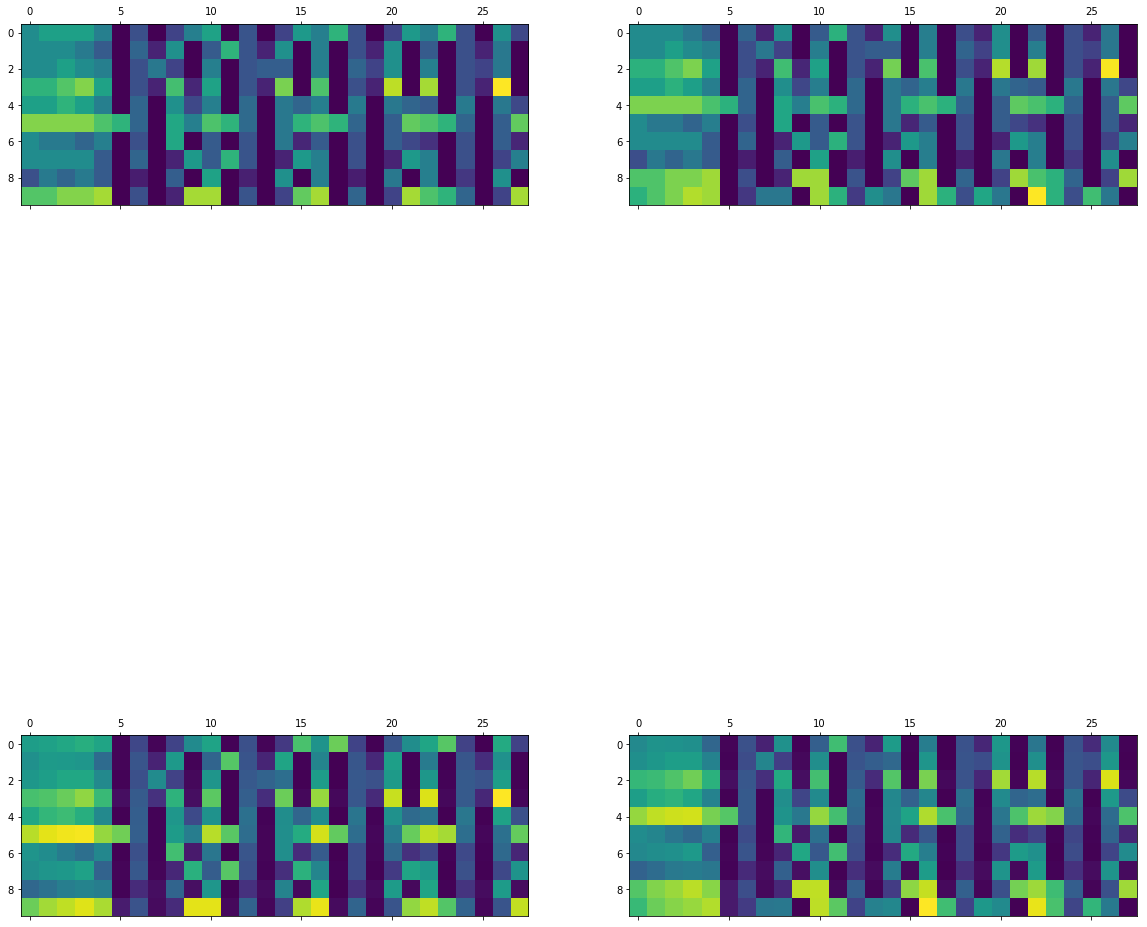

In [14]:
X_train4, X_test4 = train_test_split(normal4, test_size=0.1, random_state=920)
lost4,error4 = train(X_train4, X_test4)

In [15]:
print(error4)

0.001452602168551688
